## Preps

In [1]:
!pip install wandb -q

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!pip3 install torch>=1.3.0 subword-nmt

In [3]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

--2024-12-02 18:45:32--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2024-12-02 18:45:32--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc027cc36257314c8463e10ed362.dl.dropboxusercontent.com/cd/0/inline/Cfhj4L1V_q-m0LIqdXc7d78BJcUBtqkVbLK0G2-aqkhy4WEN5V-jzskRxZlfG1Tl5-xzWkaw5n8HcKPP9MbshoOSCjqwX8aQjwz31G3eKNltSqwkqhqBYhZWVt64QonWwkk/file?dl=1# [following]
--2024-12-02 18:45:33--  https://uc027cc36257314c8463e10ed362.dl.dropboxusercontent.com/cd/0/inline/Cfhj4L1V_q-m0L

In [4]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:12<00:00, 652.82it/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.model_selection import train_test_split

data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [7]:
from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


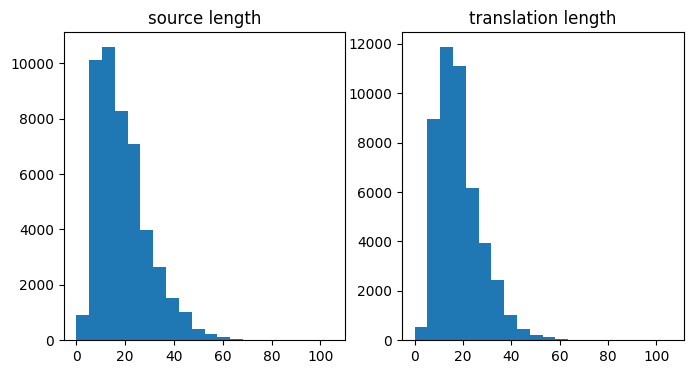

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

## Encoder-Decoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        embds = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(embds, prev_gru0_state)

        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for _ in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
woods tents poster citad@@ eat share holiday up bon@@ rain@@ gorod ux@@ linate quietly dut@@ guin@@ ables approximately silv@@ snow@@ hov drinks equi@@ und@@ dumont
woods tents poster citad@@ eat share holiday up bon@@ rain@@ gorod ux@@ linate quietly dut@@ guin@@ ables approximately silv@@ snow@@ hov drinks equi@@ und@@ dumont
woods tents poster citad@@ eat share holiday up bon@@ rain@@ gorod ux@@ linate quietly dut@@ guin@@ ables approximately silv@@ snow@@ hov drinks equi@@ und@@ dumont


In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """

    mask = model.out_voc.compute_mask(out)
    targets_one_hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    logits_seq = model(inp, out)

    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    logp_out = (logprobs_seq * targets_one_hot).sum(dim=-1)

    logp_out_mask = logp_out * mask

    sum_y = torch.sum(-logp_out_mask, axis=1)

    sum_batch = torch.sum(sum_y)
    return sum_batch / torch.sum(mask)

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5998, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.inference_mode():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0017848015505549676

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

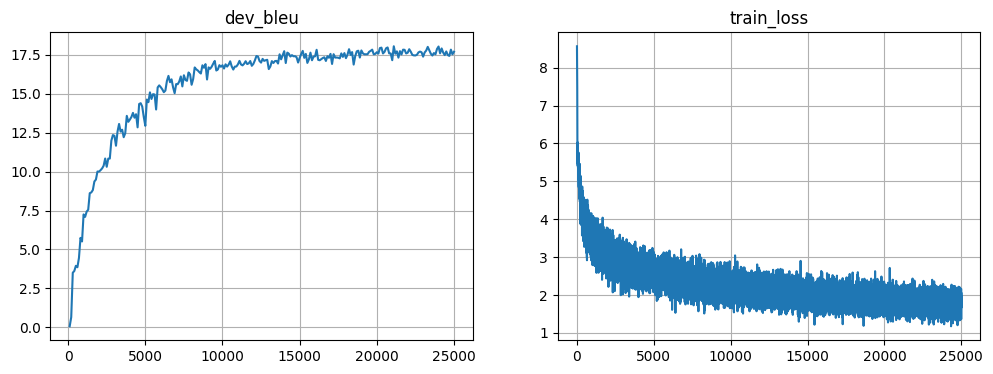

Mean loss=1.801


bleu,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇█▇███████████████
loss,▇█▅▄▄▃▄▄▄▄▃▃▃▂▂▃▂▂▃▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▂
bleu,17.68137
loss,1.72963


In [ ]:
run = wandb.init(project="encoder-decoder")
config = run.config
config.learning_rate = learning_rate
config.batch_size = batch_size

for _ in trange(25_000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    loss_t = compute_loss(model, batch_inp, batch_out)
    opt.zero_grad()
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))
    run.log({"loss": loss_t.item()})

    if step % 100 == 0:
        bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, bleu))
        run.log({"bleu": bleu})

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
run.finish()

[wandb report](https://api.wandb.ai/links/max_wpeg-hse/pq766dzv)

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
guests can also make use of the shoe shine and free shuttle services to a charge .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the town of rethym@@ national park is 6 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in a beach , cabañas villa del mar is a self - catering accommodation located in trapani , a 5 - minute walk from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
set in a renovated building , apartment vino@@ hr@@ ady is located in nizh@@ niy novgorod kremlin .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the bathroom is fitted with a s

## Attention

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        self.linear_e = nn.Linear(self.enc_size, self.hid_size)
        self.linear_d = nn.Linear(self.dec_size, self.hid_size)
        self.linear_out = nn.Linear(self.hid_size, 1)


    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        logits = self.linear_out(self.activ(self.linear_e(enc) + self.linear_d(dec).unsqueeze(1))).squeeze()

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        logits_mask = torch.where(inp_mask, logits, -1e9)

        # Compute attention probabilities
        probs = torch.log_softmax(logits_mask, dim=-1)

        # Compute attention response using enc and probs
        attn = torch.sum(probs.unsqueeze(2) * enc, dim=1)

        return attn, probs

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.attention = AttentionLayer(hid_size, hid_size, attn_size)
        self.dec = nn.GRUCell(hid_size + emb_size, hid_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)

        mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq,dec_start,mask)[1]

        first_state = [dec_start, enc_seq, mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, mask, _ = prev_state
        embds = self.emb_out(prev_tokens)
        attention, probs = self.attention(enc_seq, prev_gru0_state, mask)
        new_token = torch.cat((embds, attention), dim=-1)
        new_dec_state = self.dec(new_token,prev_gru0_state)

        output_logits = self.logits(new_dec_state)
        new_dec_state = [new_dec_state, enc_seq, mask, probs]
        return [new_dec_state, output_logits]

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel('Attention', inp_voc, out_voc).to(device)
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

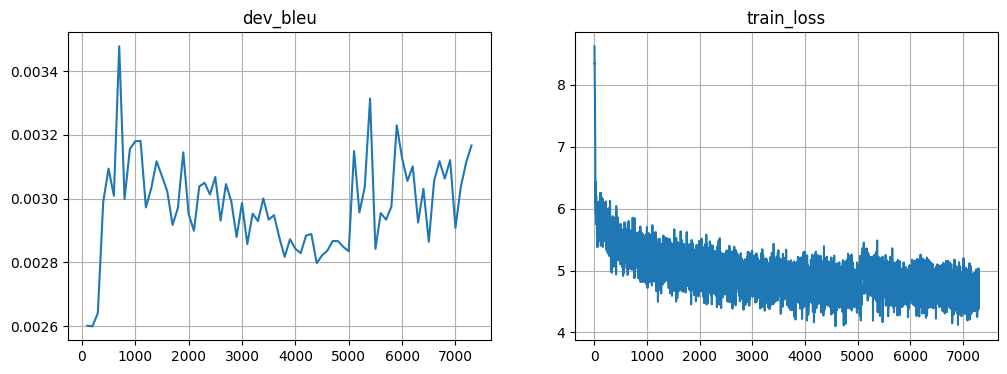

Mean loss=4.703


In [ ]:
run = wandb.init(project="seq2seq attentive model")
config = run.config
config.learning_rate = learning_rate
config.batch_size = batch_size

for _ in trange(25_000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    opt.zero_grad()

    metrics['train_loss'].append((step, loss_t.item()))
    run.log({"loss": loss_t.item()})

    if step % 100 == 0:
        bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, bleu))
        run.log({"bleu": bleu})

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
run.finish()

[wandb](https://wandb.ai/max_wpeg-hse/seq2seq%20attentive%20model/reports/seq2seq-attentive-model--VmlldzoxMDQxMDY1Mg?accessToken=5gqgqpvc6so3pv0pq7qpjrsk9tqjgkx2ir2e85j48lzgdvi1rm6oj8pgn8cax29b)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0028263612516345763

In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

attention_probs = np.stack([state[-1].detach().cpu().numpy() for state in states], axis=1)

In [ ]:
for i in range(3):
    draw_attention(inp[i], trans[i], attention_probs[i])